In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
np.random.seed(9)
# import pixiedust  # debugger
# # %%pixie_debugger

# Data Cleaning, Preprocessing  and Visualization

In [2]:
data = pd.read_csv("./data/creditcard.csv")
data.shape

(284807, 31)

In [3]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
display(data.head(),data.tail())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


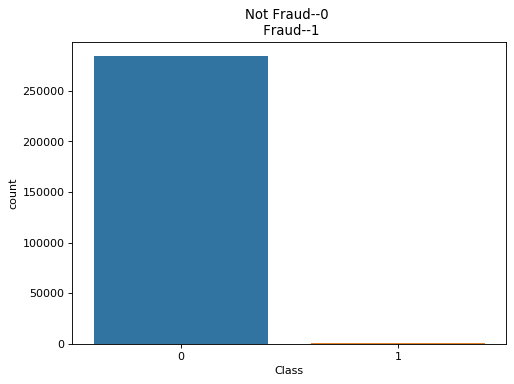

In [5]:
plt.figure(figsize=(7, 5),dpi=80, frameon=False, clear=True)
sns.countplot(x="Class", data=data)
plt.title("Not Fraud--0 \n Fraud--1")
plt.show()

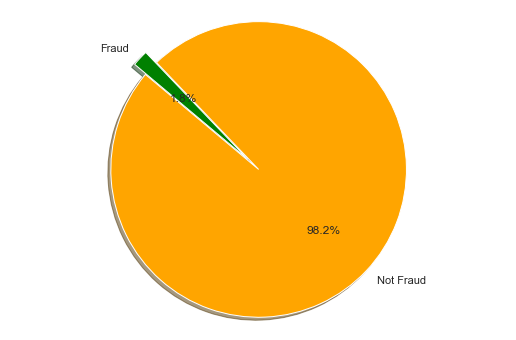

In [132]:
plt.figure(figsize=(9,6))
labels = 'Not Fraud', 'Fraud'
sizes = [28000, 500]
colors = ['orange', 'green']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

# Handling the Imbalanced Dataset
We can see this dataset is imbalanced.
So our idea to build this model is we filter all of class 1 (492 counts) which labeled fraud, and filter the same number of class 0, and combine them. Then we can get our new dataset, but we only get about 1000 data by this method, and it is not enough. So we will use the cross validation.

In [7]:
# Split X and y
X = data.drop("Class",axis=1)
y = data["Class"]

# filter the "Class" feature with label 1, and these are "fraud"
X_fraud = data.loc[data["Class"] == 1].drop("Class",axis=1).reset_index(drop=True)
y_fraud = data.loc[data["Class"] == 1, "Class"].reset_index(drop=True)

# filter the "Class" feature with label 0, and these are "not fraud"
X_Notfraud = data.loc[data["Class"] == 0].drop("Class",axis=1).reset_index(drop=True)
y_Notfraud = data.loc[data["Class"] == 0]["Class"].reset_index(drop=True)

In [8]:
# filter the data with fraud and not fraud
data_fraud = data.loc[data["Class"] == 1].reset_index(drop=True)
data_Notfraud = data.loc[data["Class"] == 0].reset_index(drop=True)

In [9]:
# We create 20 datasets, and each dataset has almost 50% label 1 and 50% label 0.
data_list = list()
temp_Notfraud = data_Notfraud
for i in range(20):
    temp = temp_Notfraud.iloc[0:500].reset_index(drop=True)
    temp_Notfraud.drop(temp_Notfraud.head(500).index, axis=0, inplace=True)
    temp_concat = pd.concat([temp, data_fraud], ignore_index=True).sample(frac=1).reset_index(drop=True)
    data_list.append(temp_concat)

In [10]:
# check the data_list
display(data_list[0].head(5), data_list[0].tail(5))

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1,86376.0,-0.670238,0.945206,0.610051,2.640065,-2.707775,1.952611,-1.624608,-5.229908,0.210202,...,-2.504450,1.436472,0.351542,0.648467,0.579681,0.075738,0.346717,0.282209,323.77,1
2,41743.0,-2.144411,1.073499,-2.773663,1.384394,-4.015477,0.747235,1.525638,0.192988,-2.431862,...,0.144653,-0.885682,0.625099,0.096527,-0.189455,0.532908,0.423045,-0.210266,802.52,1
3,51112.0,-9.848776,7.365546,-12.898538,4.273323,-7.611991,-3.427045,-8.350808,6.863604,-2.387567,...,0.931958,-0.874467,-0.192639,-0.035426,0.538665,-0.263934,1.134095,0.225973,99.99,1
4,40742.0,-2.377533,0.520539,-8.094139,8.005351,2.640750,-3.381586,-1.934372,0.562322,-3.104027,...,0.148284,0.721100,2.661291,-0.508620,-0.401657,0.587611,0.500326,0.551760,1.00,1


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
987,153761.0,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,...,0.564450,0.445744,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,51.37,1
988,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
989,41851.0,-19.139733,9.286847,-20.134992,7.818673,-15.652208,-1.668348,-21.340478,0.641900,-8.550110,...,-2.182692,0.520543,-0.760556,0.662767,-0.948454,0.121796,-3.381843,-1.256524,139.90,1
990,258.0,1.130933,0.178069,0.533440,1.478955,-0.342933,-0.379986,0.063253,-0.022391,0.312978,...,-0.080364,-0.022293,-0.023433,0.400434,0.607259,-0.332017,0.037441,0.019527,13.79,0
991,280.0,0.878794,-0.266909,0.409706,1.509808,-0.487798,0.376829,-0.389288,0.331361,0.702728,...,0.025056,0.110527,-0.191237,-0.059199,0.504350,-0.271526,0.059100,0.053501,109.15,0


# PCA Dimensionality Reduction
There are 30 features in this dataset, and we will try to do dimensionality reduction to aviod to dimension curse, and make it simpler, and faster when we train the model.

In [11]:
scaler = StandardScaler()
scaler.fit(X)
pca=PCA()
pca.fit(X)
# explained_variance_ratio_：Percentage of variance explained by each of the selected components.
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1

# Choose the number of dimensions that add ip to a sufficiently large portion of the variance,
# and we set it to 99%.
pca = PCA(n_components=0.99)

# fit_transform is one of the methods of sklearn.preprocessing.StandardScaler
X_reduced = pca.fit_transform(X)

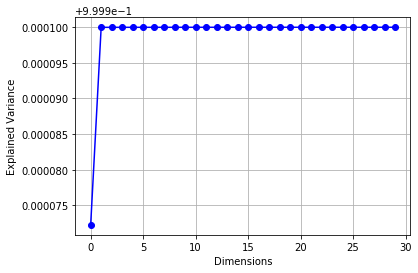

In [12]:
plt.figure(figsize=(6,4))
plt.plot(cumsum,'bo-')
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

In [13]:
# explained_variance_ratio_：Percentage of variance explained by each of the selected components.
pca.explained_variance_ratio_

array([0.99997225])

## Biplot

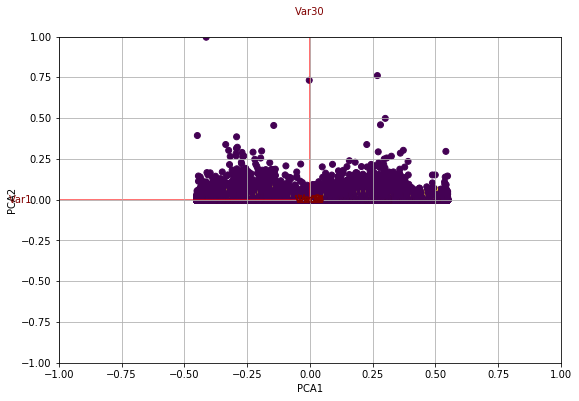

In [14]:
# Plot PCA loadings and loading in biplot
pca = PCA()
X_new = pca.fit_transform(X)

scalex = 1.0/(X_new[:,0].max() - X_new[:,0].min())
scaley = 1.0/(X_new[:,1].max() - X_new[:,1].min())
n = np.transpose(pca.components_[0:2, :]).shape[0]

plt.figure(figsize=(9,6))
plt.scatter(X_new[:,0] * scalex, X_new[:,1] * scaley, c=y)
for i in range(n):
        plt.arrow(0, 0, np.transpose(pca.components_[0:2, :])[i,0], np.transpose(pca.components_[0:2, :])[i,1],color = 'r',alpha = 0.5)
        plt.text(np.transpose(pca.components_[0:2, :])[i,0]* 1.15, np.transpose(pca.components_[0:2, :])[i,1] * 1.15, "Var"+str(i+1), color = 'maroon', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.show()

var1 represents "Time" feature, and var30 represents "Amount" feature.

The yellow points in this graph represent "fraud behevior", but all of these yellow points are overlapped by the purpule points which are "not fraud".

I don't think it is good to use kmeans algorithm in this dataset.

## Visualization (density plot)

### Not Fraud (Time & Amount)

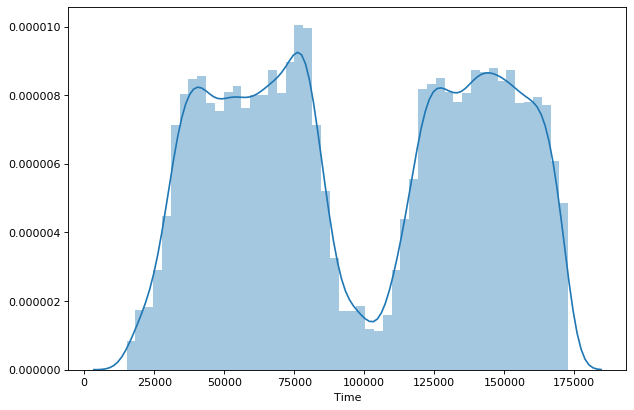

In [15]:
# Time --> Not Fraud
plt.figure(figsize=(9, 6), dpi=80, frameon=False, clear=True)
sns.distplot(data_Notfraud["Time"])
plt.show()

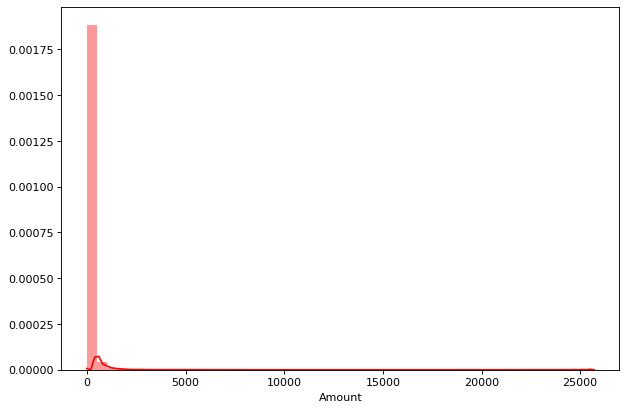

In [16]:
# Amount --> Not Fraud
plt.figure(figsize=(9, 6),dpi=80, frameon=False, clear=True)
sns.distplot(data_Notfraud["Amount"], color='red')
plt.show()

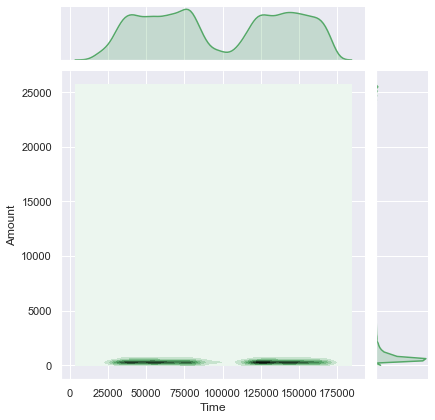

In [17]:
# jointplot of Not Fraud 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.jointplot(x = 'Time', y = 'Amount', data = data_Notfraud, kind = 'kde', color="g")

### Fraud (Time & Amount)

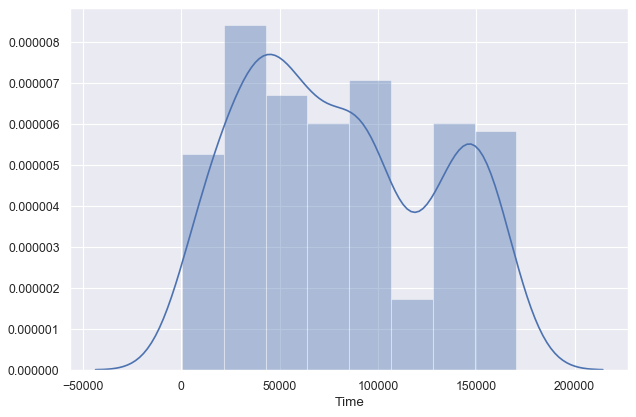

In [18]:
plt.figure(figsize=(9, 6), dpi=80, frameon=False, clear=True)
sns.distplot(data_fraud["Time"])
plt.show()

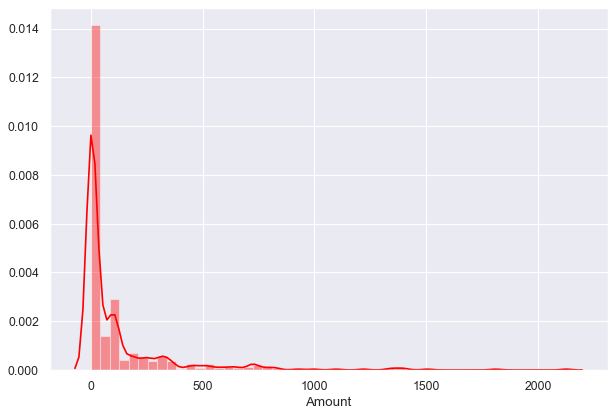

In [19]:
plt.figure(figsize=(9, 6), dpi=80, frameon=False, clear=True)
sns.distplot(data_fraud["Amount"],color='red')
plt.show()

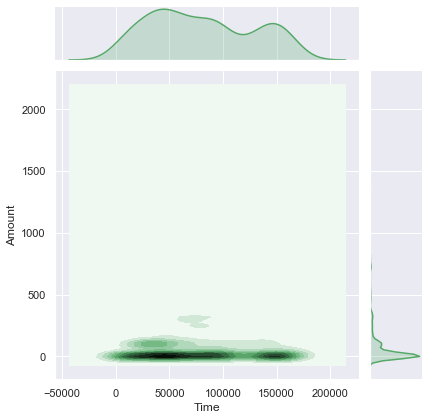

In [20]:
# jointplot of Fraud 
sns.jointplot(x = 'Time', y = 'Amount', data = data_fraud, kind = "kde", color="g")

## Density plot of several variables

Text(0.5, 0, 'Time')

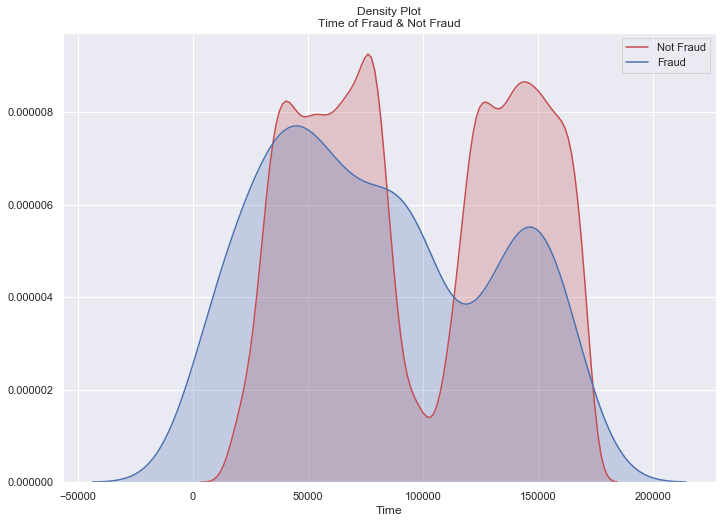

In [21]:
p1 = sns.kdeplot(data_Notfraud["Time"], shade=True, color="r", label="Not Fraud")
p2 = sns.kdeplot(data_fraud["Time"], shade=True, color="b", label="Fraud").set_title("Density Plot\nTime of Fraud & Not Fraud")
plt.xlabel("Time")

Text(0.5, 0, 'Amount')

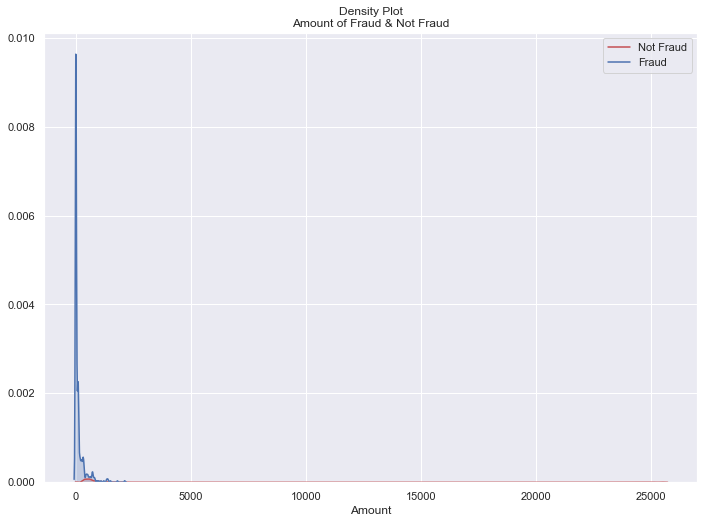

In [22]:
p3 = sns.kdeplot(data_Notfraud["Amount"], shade=True, color="r", label="Not Fraud")
p4 = sns.kdeplot(data_fraud["Amount"], shade=True, color="b", label="Fraud").set_title("Density Plot\nAmount of Fraud & Not Fraud")
plt.xlabel("Amount")

# Kmeans Algorithm

In [23]:
start = time.time()
Sum_of_squared_distances = []
K = range(1,9)
for k in K:
    '''
    'k-means++' : selects initial cluster centers for k-mean clustering in a smart way 
    to speed up convergence. See section Notes in k_init for more details.
    '''
    km = KMeans(n_clusters=k, init='k-means++')
    km = km.fit(X)
#   km.inertia_ --> Sum of squared distances of samples to their closest cluster center
    Sum_of_squared_distances.append(km.inertia_)
end = time.time()
print('The time of running is: {0}\'s'.format(end-start))

The time of running is: 121.41094040870667's


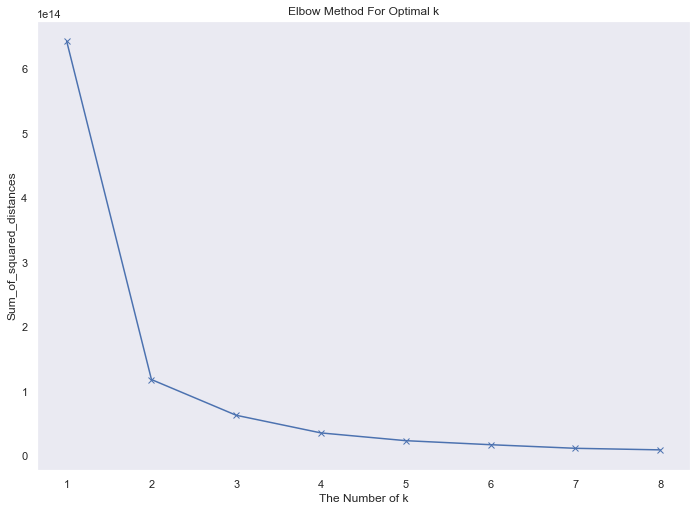

In [24]:
# Elbow Method For Optimal k
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('The Number of k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

From this graph, we choose 3 clusters.

But we do not think cluster analysis is helpful to our model, so we give up Kmeans.


The top 5% of the farthest point from cluster centers are itentified as fraud (outliers).

This idea comes from: https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest

In [87]:
X = data.drop("Class",axis=1)
y = data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

kmeans = KMeans(n_clusters=2, random_state=42,n_jobs=-1).fit(X_train)
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0
# Confusion Matrix
km_cm = confusion_matrix(y_test, km_y_pred)

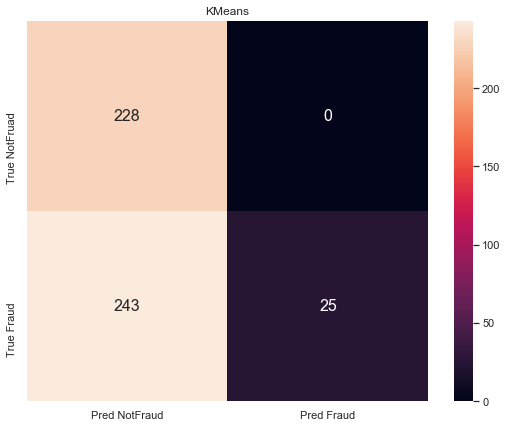

In [89]:
df_cm = pd.DataFrame(km_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("KMeans")

# sns.heatmap top and bottom boxes are cut off: https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

# Stochastic Gradient Descent (SGD) Learning
Disadvantages:
1. SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

2. SGD is sensitive to feature scaling.

In [27]:
# scale the data in data_list
for data in data_list:
    scaler = StandardScaler()
    scaler.fit(data)

In [28]:
# store the accuarcy of each sub-dataset
accuarcy_sgd_train = []
accuarcy_sgd_test = []

# Use each sub-dataset of data_list to training the model
i = 1
start = time.time()
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    
    clf = SGDClassifier(loss="hinge", max_iter=2500, learning_rate='optimal')
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, clf.score(X_train, y_train), clf.score(X_test, y_test)))
    i = i + 1
    accuarcy_sgd_train.append(clf.score(X_train, y_train))
    accuarcy_sgd_test.append(clf.score(X_test, y_test))
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_sgd_train = np.array(accuarcy_sgd_train)
accuarcy_sgd_test = np.array(accuarcy_sgd_test)

The 1'th fold:
The Accuarcy of Training Set is: 0.7520161290322581
The Accuarcy of Testing Set is: 0.7560483870967742
The 2'th fold:
The Accuarcy of Training Set is: 0.780241935483871
The Accuarcy of Testing Set is: 0.7782258064516129
The 3'th fold:
The Accuarcy of Training Set is: 0.6794354838709677
The Accuarcy of Testing Set is: 0.6935483870967742
The 4'th fold:
The Accuarcy of Training Set is: 0.5685483870967742
The Accuarcy of Testing Set is: 0.4596774193548387
The 5'th fold:
The Accuarcy of Training Set is: 0.4959677419354839
The Accuarcy of Testing Set is: 0.5120967741935484
The 6'th fold:
The Accuarcy of Training Set is: 0.5221774193548387
The Accuarcy of Testing Set is: 0.5060483870967742
The 7'th fold:
The Accuarcy of Training Set is: 0.5
The Accuarcy of Testing Set is: 0.49193548387096775
The 8'th fold:
The Accuarcy of Training Set is: 0.6310483870967742
The Accuarcy of Testing Set is: 0.6068548387096774
The 9'th fold:
The Accuarcy of Training Set is: 0.5342741935483871
The 

In [29]:
display(accuarcy_sgd_train.mean(), accuarcy_sgd_test.mean())

0.547983870967742

0.5448588709677419

# Kernel Trick & Support Vector Machine

## svm.SVC (C-Support Vector Classification)
### kernel = 'linear'
linear is so slow but with high accuarcy. After we set parameter probability = True. It is really really slow! But we must use probability to estimate the model, because ROC Curve require probability to estimate.

In [90]:
# store the accuarcy of each sub-dataset
accuarcy_svm_train = []
accuarcy_svm_test = []

# Use each sub-dataset of data_list to training the model
i = 1
start = time.time()
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

#     clf = svm.SVC(kernel='linear', gamma='auto', probability=True)
    clf = svm.SVC(kernel='linear')
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, clf.score(X_train, y_train), clf.score(X_test, y_test)))
    i = i + 1
    accuarcy_svm_train.append(clf.score(X_train, y_train))
    accuarcy_svm_test.append(clf.score(X_test, y_test))
    # ROC
#     y_prob_svm = clf.predict_proba(X_test)[:,1]
#     fpr_svm, tpr_svm, svm_ = roc_curve(y_test, y_prob_svm)
    
    # Confusion Matrix
    svm_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_svm_train = np.array(accuarcy_svm_train)
accuarcy_svm_test = np.array(accuarcy_svm_test)

The 1'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 2'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 3'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 5'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9939516129032258
The 6'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 7'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 8'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 9'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9939516129032258
The 10'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839

In [31]:
# mean of accuarcy of training and test data(SVM)
display(accuarcy_svm_train.mean(), accuarcy_svm_test.mean())

0.9991935483870966

0.9948588709677418

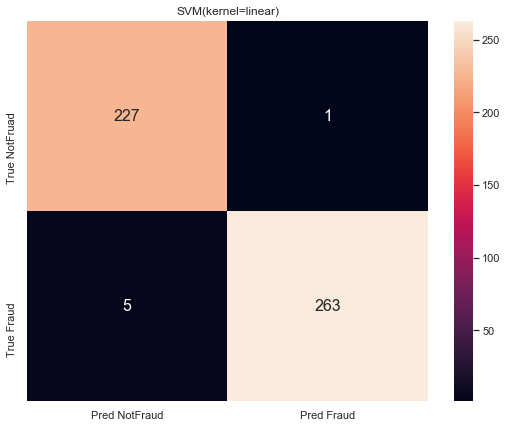

In [91]:
# Confusion Matrix
df_cm = pd.DataFrame(svm_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("SVM(kernel=linear)")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

### kernel = 'rbf'
rbf is one of most popular kernel, and is really fast but with low accuarcy. 

In [32]:
# store the accuarcy of each sub-dataset
accuarcy_svm_train1 = []
accuarcy_svm_test1 = []

# Use each sub-dataset of data_list to training the model
i = 1
start = time.time()
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

    clf = svm.SVC(kernel='rbf', gamma='auto', probability=True)
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, clf.score(X_train, y_train), clf.score(X_test, y_test)))
    i = i + 1
    accuarcy_svm_train1.append(clf.score(X_train, y_train))
    accuarcy_svm_test1.append(clf.score(X_test, y_test))
    # ROC
    y_prob_svm1 = clf.predict_proba(X_test)[:,1]
    fpr_svm1, tpr_svm1, svm1_ = roc_curve(y_test, y_prob_svm1)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_svm_train1 = np.array(accuarcy_svm_train1)
accuarcy_svm_test1 = np.array(accuarcy_svm_test1)

The 1'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7762096774193549
The 2'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7600806451612904
The 3'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.8387096774193549
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7137096774193549
The 5'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7560483870967742
The 6'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7782258064516129
The 7'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7641129032258065
The 8'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.7278225806451613
The 9'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.8508064516129032
The 10'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Test

In [33]:
# mean of accuarcy of training and test data(SVM)
display(accuarcy_svm_train1.mean(), accuarcy_svm_test1.mean())

1.0

0.7283266129032259

## sklearn.svm.LinearSVC (Linear Support Vector Classification)
We increase the max_inter from 1000(default by sklearn) to 1800, but the consequences are not stable. Somethimes when we set to 1500, we got over 90% accuarcy, but sometimes we got 60% - 70% accuarcy.

In [34]:
# store the accuarcy of each sub-dataset
accuarcy_svm_train2 = []
accuarcy_svm_test2 = []

i = 1
start = time.time()
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    
    # max_iter=1000 is default, but it has very low accuarcy, so we increase the iterations.
    clf = svm.LinearSVC(max_iter=1600)  
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, clf.score(X_train, y_train), clf.score(X_test, y_test)))
    i = i + 1
    accuarcy_svm_train2.append(clf.score(X_train, y_train))
    accuarcy_svm_test2.append(clf.score(X_test, y_test))
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_svm_train2 = np.array(accuarcy_svm_train2)
accuarcy_svm_test2 = np.array(accuarcy_svm_test2)

The 1'th fold:
The Accuarcy of Training Set is: 0.9334677419354839
The Accuarcy of Testing Set is: 0.9455645161290323


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 2'th fold:
The Accuarcy of Training Set is: 0.49798387096774194
The Accuarcy of Testing Set is: 0.5120967741935484
The 3'th fold:
The Accuarcy of Training Set is: 0.9858870967741935
The Accuarcy of Testing Set is: 0.9858870967741935


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 4'th fold:
The Accuarcy of Training Set is: 0.9798387096774194
The Accuarcy of Testing Set is: 0.9717741935483871
The 5'th fold:
The Accuarcy of Training Set is: 0.9737903225806451
The Accuarcy of Testing Set is: 0.9778225806451613


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 6'th fold:
The Accuarcy of Training Set is: 0.5
The Accuarcy of Testing Set is: 0.5100806451612904
The 7'th fold:
The Accuarcy of Training Set is: 0.8528225806451613
The Accuarcy of Testing Set is: 0.8568548387096774
The 8'th fold:
The Accuarcy of Training Set is: 0.4959677419354839
The Accuarcy of Testing Set is: 0.5161290322580645


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 9'th fold:
The Accuarcy of Training Set is: 0.9032258064516129
The Accuarcy of Testing Set is: 0.9173387096774194
The 10'th fold:
The Accuarcy of Training Set is: 0.6068548387096774
The Accuarcy of Testing Set is: 0.5846774193548387
The 11'th fold:
The Accuarcy of Training Set is: 0.5060483870967742
The Accuarcy of Testing Set is: 0.5262096774193549


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 12'th fold:
The Accuarcy of Training Set is: 0.8629032258064516
The Accuarcy of Testing Set is: 0.842741935483871
The 13'th fold:
The Accuarcy of Training Set is: 0.5262096774193549
The Accuarcy of Testing Set is: 0.4657258064516129
The 14'th fold:
The Accuarcy of Training Set is: 0.47580645161290325
The Accuarcy of Testing Set is: 0.5161290322580645


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 15'th fold:
The Accuarcy of Training Set is: 0.6592741935483871
The Accuarcy of Testing Set is: 0.6754032258064516
The 16'th fold:
The Accuarcy of Training Set is: 0.4939516129032258
The Accuarcy of Testing Set is: 0.49798387096774194
The 17'th fold:
The Accuarcy of Training Set is: 0.5625
The Accuarcy of Testing Set is: 0.5725806451612904


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


The 18'th fold:
The Accuarcy of Training Set is: 0.48588709677419356
The Accuarcy of Testing Set is: 0.5060483870967742
The 19'th fold:
The Accuarcy of Training Set is: 0.5625
The Accuarcy of Testing Set is: 0.5826612903225806
The 20'th fold:
The Accuarcy of Training Set is: 0.45161290322580644
The Accuarcy of Testing Set is: 0.5403225806451613

The time of training this model is: 2.035588264465332's


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [35]:
# mean of accuarcy of training and test data(svm.LinearSVC)
display(accuarcy_svm_train2.mean(), accuarcy_svm_test2.mean())

0.6658266129032258

0.6752016129032257

# Naives Bayes

In [92]:
# store the accuarcy of each sub-dataset
accuarcy_gnb_train = []
accuarcy_gnb_test = []
# store the misclassification of data of test set
misclass_gnb = []

i = 1
start = time.time()
# Use each sub-dataset of data_list to training the model
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, gnb.score(X_train, y_train), gnb.score(X_test, y_test)))
    i += 1
    accuarcy_gnb_train.append(gnb.score(X_train, y_train))
    accuarcy_gnb_test.append(gnb.score(X_test, y_test))
    
    # get the misclassification data, and store these data in the list
    for j in range(len(y_test)-1):
        if y_pred.tolist()[j] != y_test.tolist()[j]:
            misclass_gnb.append(data.iloc[j])
            # print('The {0}\'th data misclassification.\n{1}'.format(i, data.iloc[i]))

    # ROC
    y_prob_gnb = gnb.predict_proba(X_test)[:,1]
    fpr_gnb, tpr_gnb, gnb_ = roc_curve(y_test, y_prob_gnb)
    
    # Confusion Matrix
    gnb_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_gnb_train = np.array(accuarcy_gnb_train)
accuarcy_gnb_test = np.array(accuarcy_gnb_test)
# change list to DataFrame
misclass_gnb_DF = pd.DataFrame(misclass_gnb)

The 1'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 2'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 3'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 1.0
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 5'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9959677419354839
The 6'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 0.9879032258064516
The 7'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 1.0
The 8'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 1.0
The 9'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 10'th fol

In [37]:
# mean of accuarcy of training and test data(Naives Bayes)
display(accuarcy_gnb_train.mean(), accuarcy_gnb_test.mean())

0.9961693548387096

0.9958669354838708

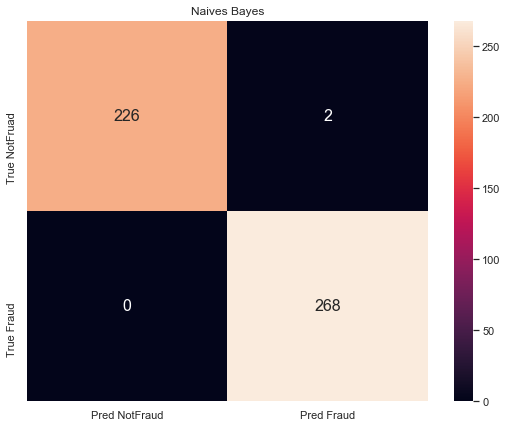

In [93]:
# Confusion Matrix
df_cm = pd.DataFrame(gnb_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("Naives Bayes")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

## Get the Misclassification data (Naive Bayes)


In [38]:
# glimpse of misclassfication data
misclass_gnb_DF

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177,294.0,-0.745116,0.446440,1.714154,-0.146626,-0.244287,-0.963058,0.566537,-0.044998,0.274475,...,-0.149227,-0.440704,0.088860,0.708177,-0.570540,0.036992,-0.041732,0.182178,33.33,0.0
273,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.00,0.0
215,155054.0,-0.512349,4.827060,-7.973939,7.334059,0.367704,-2.055129,-2.935856,1.431008,-4.544722,...,0.535620,-0.459496,-0.009364,-1.140436,-0.006445,0.527970,0.558881,0.126517,0.77,1.0
371,1872.0,1.225527,0.162027,0.429648,0.498751,-0.294345,-0.509616,-0.038838,-0.087049,0.067447,...,-0.040250,-0.028838,0.036205,0.128270,0.315152,0.440023,-0.019698,0.010250,1.69,0.0
68,155535.0,0.711155,2.617105,-4.722363,5.842970,-0.600179,-1.646313,-2.785198,0.540368,-3.044029,...,0.360501,-0.865526,0.139978,-0.336238,0.128449,-0.155646,0.799460,0.392170,3.90,1.0
83,2398.0,1.213222,-0.098784,0.722226,0.052009,-0.687750,-0.456824,-0.372861,0.029202,0.416117,...,-0.167388,-0.478142,0.185310,0.112675,-0.071837,0.818409,-0.047962,0.011504,8.07,0.0
183,100298.0,-22.341889,15.536133,-22.865228,7.043374,-14.183129,-0.463145,-28.215112,-14.607791,-9.481456,...,-9.110423,4.158895,1.412928,0.382801,0.447154,-0.632816,-4.380154,-0.467863,1.00,1.0
214,2251.0,1.409459,-1.238930,0.878479,-1.426780,-1.801537,-0.157437,-1.523010,0.204894,-1.682813,...,0.013901,0.405617,0.062609,0.194234,0.170519,-0.099224,0.057798,0.012060,6.00,0.0
340,2216.0,-0.533132,0.535842,1.297676,0.211294,0.434610,1.274418,0.641687,0.307801,-0.652154,...,0.260299,0.603879,-0.122554,-1.341353,0.184051,-0.251462,0.073311,0.055107,116.90,0.0
385,2549.0,1.215314,0.523792,-0.144504,1.409172,-0.320571,-1.434964,0.160138,-0.144819,0.217257,...,-0.054926,-0.192335,-0.053462,0.545008,0.576136,-0.340671,0.018457,0.050005,1.00,0.0


# Random Forest

In [94]:
# store the accuarcy of each sub-dataset
accuarcy_rdf_train = []
accuarcy_rdf_test = []
# store the misclassification of data of test set
misclass_rdf = []

i = 1
start = time.time()
# Use each sub-dataset of data_list to training the model
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    rdf = RandomForestClassifier()
    y_pred = rdf.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, rdf.score(X_train, y_train), rdf.score(X_test, y_test)))
    i += 1
    accuarcy_rdf_train.append(rdf.score(X_train, y_train))
    accuarcy_rdf_test.append(rdf.score(X_test, y_test))
    
    # get the misclassification data, and store these data in the list
    for j in range(len(y_test)-1):
        if y_pred.tolist()[j] != y_test.tolist()[j]:
            misclass_rdf.append(data.iloc[j])
            # print('The {0}\'th data misclassification.\n{1}'.format(i, data.iloc[i]))
    
    # ROC
    y_prob_rdf = rdf.predict_proba(X_test)[:,1]
    fpr_rdf, tpr_rdf, rdf_ = roc_curve(y_test, y_prob_rdf)
    # Confusion Matrix
    rdf_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_rdf_train = np.array(accuarcy_rdf_train)
accuarcy_rdf_test = np.array(accuarcy_rdf_test)
# change list to DataFrame
misclass_rdf_DF = pd.DataFrame(misclass_rdf)

C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

The 1'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 2'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 3'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 1.0
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9879032258064516
The 5'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

The 6'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9758064516129032
The 7'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 8'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 9'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 10'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

The 11'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9939516129032258
The 12'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 13'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 14'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 15'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419


C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

The 16'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 17'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9959677419354839
The 18'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9939516129032258
The 19'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9979838709677419
The 20'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9899193548387096

The time of training this model is: 0.8722000122070312's


## Get the Misclassification data (Random Forest)

In [40]:
# glimpse of misclassfication data
misclass_rdf_DF

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
112,480.0,-1.448818,-1.272090,0.080647,-0.122034,-1.711966,0.611858,3.310782,-0.372438,-0.716214,...,0.456931,0.223931,1.501474,0.121536,0.375166,1.084083,-0.300847,0.050742,732.00,0.0
349,488.0,0.986168,-0.550923,1.140934,0.757901,-1.038890,0.476782,-0.837096,0.433228,0.896975,...,0.003400,-0.001184,0.017652,0.026666,0.078602,0.328056,0.008762,0.020131,64.99,0.0
453,20451.0,-15.819179,8.775997,-22.804686,11.864868,-9.092361,-2.386893,-16.560368,0.948349,-6.310658,...,-2.350634,1.036362,1.136051,-1.043414,-0.108923,0.657437,2.136424,-1.411945,1.00,1.0
483,380.0,1.158923,0.165064,0.507316,0.456052,-0.193600,-0.180777,-0.070487,0.046688,-0.302918,...,-0.166915,-0.476946,0.139460,0.028225,0.130464,0.104225,-0.014329,0.008026,9.99,0.0
170,50808.0,-9.169790,7.092197,-12.354037,4.243069,-7.176438,-3.386618,-8.058012,6.442909,-2.412987,...,0.926157,-0.817706,-0.150434,-0.039383,0.485640,-0.264325,1.159690,0.232758,99.99,1.0
17,2388.0,1.260470,-1.654448,0.520951,-1.460939,-1.753975,0.150200,-1.495795,0.288405,-1.459456,...,0.022070,0.149838,-0.071999,-0.369049,0.161910,-0.072113,0.030404,0.020573,102.00,0.0
23,41181.0,-7.334341,4.960892,-8.451410,8.174825,-7.237464,-2.382711,-11.508842,4.635798,-6.557760,...,2.153755,0.033922,-0.014095,0.625250,-0.053390,0.164709,1.411047,0.315645,11.38,1.0
72,41582.0,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,...,0.549014,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,39.45,1.0
252,62059.0,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,-2.809071,...,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,6.62,1.0
259,46149.0,-1.346509,2.132431,-1.854355,2.116998,-1.070378,-1.092671,-2.230986,1.036425,-1.895516,...,0.609508,0.202874,-0.060791,-0.186733,-0.017401,-0.283751,0.395451,0.233139,1.00,1.0


In [41]:
# mean of accuarcy of training and test data(Random Forest)
display(accuarcy_gnb_train.mean(), accuarcy_gnb_test.mean())

0.9961693548387096

0.9958669354838708

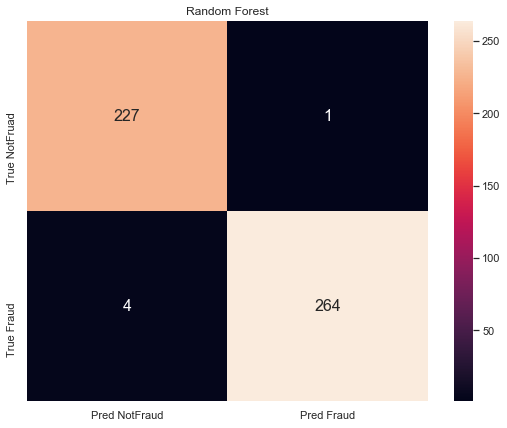

In [95]:
# Confusion Matrix
df_cm = pd.DataFrame(rdf_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("Random Forest")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

# Logistic Regression
The accuarcy is not stable.

In [42]:
# store the accuarcy of each sub-dataset
accuarcy_lg_train = []
accuarcy_lg_test = []

i = 1
start = time.time()
# Use each sub-dataset of data_list to training the model
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    lg = LogisticRegression()
    y_pred = lg.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, lg.score(X_train, y_train), lg.score(X_test, y_test)))
    i += 1
    accuarcy_lg_train.append(lg.score(X_train, y_train))
    accuarcy_lg_test.append(lg.score(X_test, y_test))
    
    # ROC
    y_prob_lg = lg.predict_proba(X_test)[:,1]
    fpr_lg, tpr_lg, lg_ = roc_curve(y_test, y_prob_lg)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_lg_train = np.array(accuarcy_lg_train)
accuarcy_lg_test = np.array(accuarcy_lg_test)

C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\l

The 1'th fold:
The Accuarcy of Training Set is: 0.8286290322580645
The Accuarcy of Testing Set is: 0.8084677419354839
The 2'th fold:
The Accuarcy of Training Set is: 0.7620967741935484
The Accuarcy of Testing Set is: 0.7600806451612904
The 3'th fold:
The Accuarcy of Training Set is: 0.8245967741935484
The Accuarcy of Testing Set is: 0.8225806451612904
The 4'th fold:
The Accuarcy of Training Set is: 0.6955645161290323
The Accuarcy of Testing Set is: 0.6088709677419355
The 5'th fold:
The Accuarcy of Training Set is: 0.9495967741935484
The Accuarcy of Testing Set is: 0.9516129032258065
The 6'th fold:
The Accuarcy of Training Set is: 0.9657258064516129
The Accuarcy of Testing Set is: 0.9616935483870968
The 7'th fold:
The Accuarcy of Training Set is: 0.9415322580645161
The Accuarcy of Testing Set is: 0.9556451612903226
The 8'th fold:
The Accuarcy of Training Set is: 0.6048387096774194
The Accuarcy of Testing Set is: 0.5766129032258065
The 9'th fold:
The Accuarcy of Training Set is: 1.0
The 

C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\zhuwe\AppData\Local\Programs\Python\Anaconda3\l

In [43]:
# mean of accuarcy of training and test data(Logistic Regression)
display(accuarcy_lg_train.mean(), accuarcy_lg_test.mean())

0.924899193548387

0.9178427419354837

# K Nearest Neighbor (KNN)

In [96]:
# store the accuarcy of each sub-dataset
accuarcy_knn_train = []
accuarcy_knn_test = []
# store the misclassification of data of test set
misclass_knn = []

i = 1
start = time.time()
# Use each sub-dataset of data_list to training the model
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    knn = KNeighborsClassifier()
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, knn.score(X_train, y_train), knn.score(X_test, y_test)))
    i += 1
    accuarcy_knn_train.append(knn.score(X_train, y_train))
    accuarcy_knn_test.append(knn.score(X_test, y_test))
    
    # get the misclassification data, and store these data in the list
    for j in range(len(y_test)-1):
        if y_pred.tolist()[j] != y_test.tolist()[j]:
            misclass_knn.append(data.iloc[j])
            # print('The {0}\'th data misclassification.\n{1}'.format(i, data.iloc[i]))
    
    # ROC
    y_prob_knn = knn.predict_proba(X_test)[:,1]
    fpr_knn, tpr_knn, knn_ = roc_curve(y_test, y_prob_knn)
    # Confusion Matrix
    knn_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_knn_train = np.array(accuarcy_knn_train)
accuarcy_knn_test = np.array(accuarcy_knn_test)
# change list to DataFrame
misclass_knn_DF = pd.DataFrame(misclass_knn)

The 1'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9979838709677419
The 2'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 1.0
The 3'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9979838709677419
The 4'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 5'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 1.0
The 6'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 1.0
The 7'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 1.0
The 8'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 1.0
The 9'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 0.9939516129032258
The 10'th fold:
The Accuarcy

## Get the Misclassification data (KNN)

In [45]:
# glimpse of misclassfication data
misclass_knn_DF

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177,294.0,-0.745116,0.446440,1.714154,-0.146626,-0.244287,-0.963058,0.566537,-0.044998,0.274475,...,-0.149227,-0.440704,0.088860,0.708177,-0.570540,0.036992,-0.041732,0.182178,33.33,0.0
193,85867.0,-3.586964,2.609127,-5.568577,3.631947,-4.543590,-0.157899,-4.089128,2.417305,-3.239901,...,1.024423,0.428756,0.182032,-0.534598,0.168933,-0.149844,0.685517,-0.299728,310.42,1.0
167,18690.0,-15.398845,7.472324,-19.026912,11.165526,-6.893856,-2.120937,-14.913330,-0.721214,-7.175097,...,-2.444884,0.727495,-0.345078,-0.981749,0.995271,0.816762,2.262942,-1.178063,1.00,1.0
190,3650.0,-0.740498,0.793632,1.464274,-0.375917,0.836770,-0.169992,0.481480,0.137202,0.611136,...,-0.263230,-0.698033,0.009143,-0.436573,-0.386430,-0.089835,0.033790,0.113442,13.99,0.0
287,153875.0,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,...,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,0.00,1.0
435,151029.0,-3.818214,2.551338,-4.759158,1.636967,-1.167900,-1.678413,-3.144732,1.245106,-1.692541,...,0.837685,0.761712,-0.417694,-0.469712,-0.225934,0.586415,-0.348107,0.087777,10.70,1.0
490,5091.0,-1.996657,0.633842,2.007773,3.139770,0.212306,0.576402,-0.186588,0.196046,-0.040092,...,0.022916,0.992860,0.513728,0.213372,-0.240347,0.240536,-0.428266,-0.224549,27.30,0.0
225,143354.0,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,-2.032638,...,0.289861,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,1.00,1.0
444,41991.0,-4.566342,3.353451,-4.572028,3.616119,-2.493138,-1.090000,-5.551433,0.447783,-2.424414,...,2.674466,-0.020880,-0.302447,-0.086396,-0.516060,-0.295102,0.195985,0.141115,1.00,1.0
493,6686.0,-1.873163,-1.160526,2.583188,-2.310487,1.179777,-0.403602,-0.752948,0.290166,2.603424,...,0.146450,0.738557,-0.109197,-0.270943,0.456031,-0.029622,0.083614,-0.093634,22.00,0.0


In [46]:
# mean of accuarcy of training and test data(Random Forest)
display(accuarcy_knn_train.mean(), accuarcy_knn_test.mean())

0.9945564516129031

0.9959677419354834

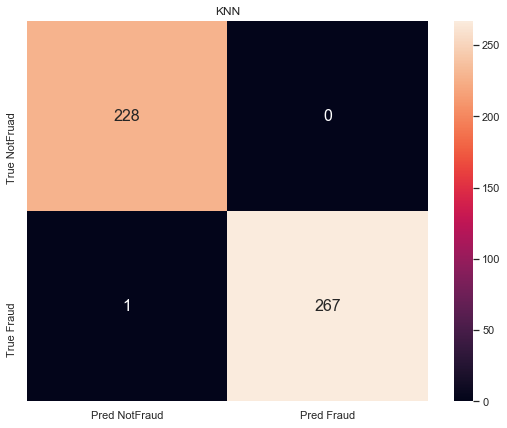

In [97]:
# Confusion Matrix
df_cm = pd.DataFrame(knn_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("KNN")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

# Feature Engineering
Create the new feature that combine the "Time" and "Amount"

In [129]:
# Create the new feature that combine the "Time" and "Amount"
for data in data_list:
    data["Time-Amount"] = data["Time"]*data["Amount"]

In [130]:
%%timeit
# Then we use Naive Bayes to train the model.
# store the accuarcy of each sub-dataset
accuarcy_gnb1_train = []
accuarcy_gnb1_test = []
# store the misclassification of data of test set
misclass_gnb1 = []

i = 1
start = time.time()
# Use each sub-dataset of data_list to training the model
for data in data_list:
    X = data.drop("Class",axis=1)
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    gnb1 = GaussianNB()
    y_pred = gnb1.fit(X_train, y_train).predict(X_test)
    
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, gnb1.score(X_train, y_train), gnb1.score(X_test, y_test)))
    i += 1
    accuarcy_gnb1_train.append(gnb1.score(X_train, y_train))
    accuarcy_gnb1_test.append(gnb1.score(X_test, y_test))
    
    # get the misclassification data, and store these data in the list
    for j in range(len(y_test)-1):
        if y_pred.tolist()[j] != y_test.tolist()[j]:
            misclass_gnb1.append(data.iloc[j])
            # print('The {0}\'th data misclassification.\n{1}'.format(i, data.iloc[i]))

    # ROC
    y_prob_gnb = gnb1.predict_proba(X_test)[:,1]
    fpr_gnb1, tpr_gnb1, gnb_1 = roc_curve(y_test, y_prob_gnb1)
    
    # Confusion Matrix
    gnb1_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_gnb_train1 = np.array(accuarcy_gnb1_train)
accuarcy_gnb_test1 = np.array(accuarcy_gnb1_test)
# change list to DataFrame
misclass_gnb_DF1 = pd.DataFrame(misclass_gnb1)

The 1'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 2'th fold:
The Accuarcy of Training Set is: 0.9899193548387096
The Accuarcy of Testing Set is: 0.9919354838709677
The 3'th fold:
The Accuarcy of Training Set is: 0.9919354838709677
The Accuarcy of Testing Set is: 0.9959677419354839
The 4'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 5'th fold:
The Accuarcy of Training Set is: 0.9919354838709677
The Accuarcy of Testing Set is: 0.9979838709677419
The 6'th fold:
The Accuarcy of Training Set is: 0.9919354838709677
The Accuarcy of Testing Set is: 0.9959677419354839
The 7'th fold:
The Accuarcy of Training Set is: 0.9899193548387096
The Accuarcy of Testing Set is: 1.0
The 8'th fold:
The Accuarcy of Training Set is: 0.9879032258064516
The Accuarcy of Testing Set is: 0.9979838709677419
The 9'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The 

The 12'th fold:
The Accuarcy of Training Set is: 0.9838709677419355
The Accuarcy of Testing Set is: 0.9717741935483871
The 13'th fold:
The Accuarcy of Training Set is: 0.9596774193548387
The Accuarcy of Testing Set is: 0.9858870967741935
The 14'th fold:
The Accuarcy of Training Set is: 0.9717741935483871
The Accuarcy of Testing Set is: 0.9778225806451613
The 15'th fold:
The Accuarcy of Training Set is: 0.9737903225806451
The Accuarcy of Testing Set is: 0.9657258064516129
The 16'th fold:
The Accuarcy of Training Set is: 0.9798387096774194
The Accuarcy of Testing Set is: 0.9758064516129032
The 17'th fold:
The Accuarcy of Training Set is: 0.9778225806451613
The Accuarcy of Testing Set is: 0.9737903225806451
The 18'th fold:
The Accuarcy of Training Set is: 0.9778225806451613
The Accuarcy of Testing Set is: 0.9879032258064516
The 19'th fold:
The Accuarcy of Training Set is: 0.9798387096774194
The Accuarcy of Testing Set is: 0.9758064516129032
The 20'th fold:
The Accuarcy of Training Set is:

The 5'th fold:
The Accuarcy of Training Set is: 0.9919354838709677
The Accuarcy of Testing Set is: 0.9979838709677419
The 6'th fold:
The Accuarcy of Training Set is: 0.9919354838709677
The Accuarcy of Testing Set is: 0.9959677419354839
The 7'th fold:
The Accuarcy of Training Set is: 0.9899193548387096
The Accuarcy of Testing Set is: 1.0
The 8'th fold:
The Accuarcy of Training Set is: 0.9879032258064516
The Accuarcy of Testing Set is: 0.9979838709677419
The 9'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9959677419354839
The 10'th fold:
The Accuarcy of Training Set is: 0.9879032258064516
The Accuarcy of Testing Set is: 0.9959677419354839
The 11'th fold:
The Accuarcy of Training Set is: 0.9818548387096774
The Accuarcy of Testing Set is: 0.9879032258064516
The 12'th fold:
The Accuarcy of Training Set is: 0.9838709677419355
The Accuarcy of Testing Set is: 0.9717741935483871
The 13'th fold:
The Accuarcy of Training Set is: 0.9596774193548387


In [113]:
# glimpse of misclassfication data
'''
The accuarcy decrease, so I don't think combine "Time" and "Amount" is a good idea to imporve the
accuarcy. If we want to imporve the accuarcy, I think we need new features.
'''
misclass_gnb_DF1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time-Amount
131,26899.0,-21.885434,12.930505,-24.098872,6.203314,-16.466099,-4.459842,-16.519836,14.535565,-3.897022,...,-1.579055,-0.951043,0.134565,1.507110,-0.222671,1.527655,0.453699,99.99,1.0,2689631.01
205,35906.0,-3.519030,4.140867,-3.628202,5.505672,-4.057463,-0.905945,-6.652031,2.634524,-4.679402,...,0.778710,-0.135707,-0.004278,0.032706,0.362014,0.900925,0.554897,9.13,1.0,327821.78
273,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.00,0.0,0.00
366,368.0,-0.409900,1.183088,1.598967,0.353088,0.309710,-0.312400,0.707197,-0.043206,-0.892869,...,-0.396155,-0.069498,0.069735,-0.298407,0.199188,0.099692,0.118617,1.98,0.0,728.64
475,75581.0,-2.866364,2.346949,-4.053307,3.983359,-3.463186,-1.280953,-4.474764,1.216655,-2.309829,...,0.475840,0.404480,0.282030,-0.506901,-0.371741,0.615257,0.803163,124.53,1.0,9412101.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,35926.0,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,-4.917130,...,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,4.56,1.0,163822.56
192,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1.0,2845472.49
226,170348.0,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,...,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,42.53,1.0,7244900.44
345,46925.0,-0.481531,1.059542,0.647117,0.905586,0.819368,-0.091184,0.504135,0.161064,-0.765054,...,0.192491,-0.174659,-0.438908,0.239259,-0.217823,-0.072852,0.010463,1.00,1.0,46925.00


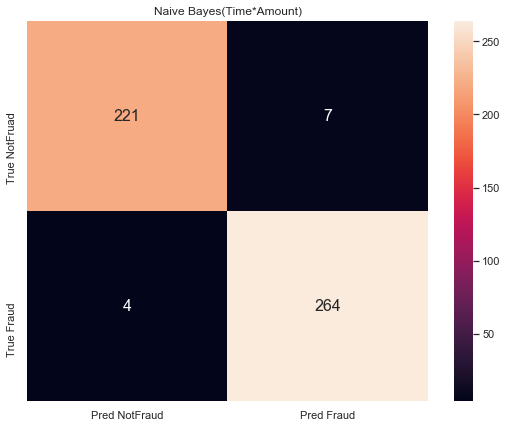

In [114]:
# Confusion Matrix
df_cm = pd.DataFrame(gnb1_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("Naive Bayes(Time*Amount)")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [115]:
# Dop the new feature which combine the "Time" and "Amount"
for data in data_list:
    data.drop("Time-Amount", axis=1, inplace=True)

## PolynomialFeatures with Naives Bayes (degree=3)

In [131]:
# %%timeit
# store the accuarcy of each sub-dataset
accuarcy_gnb2_train = []
accuarcy_gnb2_test = []
# store the misclassification of data of test set
misclass_gnb2 = []
start = time.time()
i = 1
for data in data_list:
    # fit the PolynomialFeatures
    dataPoly = data.drop("Class",axis=1)
    dataPoly = dataPoly[["Time","Amount"]]
    poly = PolynomialFeatures(degree=3, interaction_only=True)
    poly.fit_transform(dataPoly)
    
    X = dataPoly
    y = data["Class"]
    # splict the training data and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
    gnb2 = GaussianNB()
    y_pred = gnb2.fit(X_train, y_train).predict(X_test)
    print('The {0}\'th fold:\nThe Accuarcy of Training Set is: {1}\nThe Accuarcy of Testing Set is: {2}'.format(i, gnb2.score(X_train, y_train), gnb2.score(X_test, y_test)))
    
    i += 1
    accuarcy_gnb2_train.append(gnb2.score(X_train, y_train))
    accuarcy_gnb2_test.append(gnb2.score(X_test, y_test))
    
    # get the misclassification data, and store these data in the list
    for j in range(len(y_test)-1):
        if y_pred.tolist()[j] != y_test.tolist()[j]:
            misclass_gnb1.append(data.iloc[j])
            # print('The {0}\'th data misclassification.\n{1}'.format(i, data.iloc[i]))

    # ROC
    y_prob_gnb2 = gnb2.predict_proba(X_test)[:,1]
    fpr_gnb2, tpr_gnb2, gnb2_ = roc_curve(y_test, y_prob_gnb2)
    
    # Confusion Matrix
    gnb2_cm = confusion_matrix(y_test, y_pred)
    
end = time.time()
print('\nThe time of training this model is: {0}\'s'.format(end-start))
# change the list to array    
accuarcy_gnb2_train = np.array(accuarcy_gnb2_train)
accuarcy_gnb2_test = np.array(accuarcy_gnb2_test)
# change list to DataFrame
misclass_gnb2_DF = pd.DataFrame(misclass_gnb2)

The 1'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 2'th fold:
The Accuarcy of Training Set is: 0.9879032258064516
The Accuarcy of Testing Set is: 0.9919354838709677
The 3'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 5'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 6'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9959677419354839
The 7'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 8'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 0.9979838709677419
The 9'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.997983870967741

The 13'th fold:
The Accuarcy of Training Set is: 0.969758064516129
The Accuarcy of Testing Set is: 0.9838709677419355
The 14'th fold:
The Accuarcy of Training Set is: 0.9737903225806451
The Accuarcy of Testing Set is: 0.9838709677419355
The 15'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 0.9939516129032258
The 16'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 0.9818548387096774
The 17'th fold:
The Accuarcy of Training Set is: 0.9858870967741935
The Accuarcy of Testing Set is: 0.9858870967741935
The 18'th fold:
The Accuarcy of Training Set is: 0.9818548387096774
The Accuarcy of Testing Set is: 0.9919354838709677
The 19'th fold:
The Accuarcy of Training Set is: 0.9838709677419355
The Accuarcy of Testing Set is: 0.9838709677419355
The 20'th fold:
The Accuarcy of Training Set is: 0.9879032258064516
The Accuarcy of Testing Set is: 0.9838709677419355

The time of training this model is: 0.6163449287

The 3'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 4'th fold:
The Accuarcy of Training Set is: 1.0
The Accuarcy of Testing Set is: 1.0
The 5'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 6'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9959677419354839
The 7'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677419
The 8'th fold:
The Accuarcy of Training Set is: 0.9939516129032258
The Accuarcy of Testing Set is: 0.9979838709677419
The 9'th fold:
The Accuarcy of Training Set is: 0.9979838709677419
The Accuarcy of Testing Set is: 0.9979838709677419
The 10'th fold:
The Accuarcy of Training Set is: 0.9899193548387096
The Accuarcy of Testing Set is: 0.9959677419354839
The 11'th fold:
The Accuarcy of Training Set is: 0.9959677419354839
The Accuarcy of Testing Set is: 0.9979838709677

In [125]:
# glimpse of misclassfication data
misclass_gnb1_DF

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177,294.0,-0.745116,0.446440,1.714154,-0.146626,-0.244287,-0.963058,0.566537,-0.044998,0.274475,...,-0.149227,-0.440704,0.088860,0.708177,-0.570540,0.036992,-0.041732,0.182178,33.33,0.0
36,414.0,-1.043068,1.044582,0.292186,-2.378536,-0.189793,-0.920526,0.178722,-0.384095,0.237234,...,0.934064,0.316389,-0.004709,0.268738,-0.177186,-0.126936,0.290259,0.127530,1.00,0.0
205,35906.0,-3.519030,4.140867,-3.628202,5.505672,-4.057463,-0.905945,-6.652031,2.634524,-4.679402,...,1.582556,0.778710,-0.135707,-0.004278,0.032706,0.362014,0.900925,0.554897,9.13,1.0
273,430.0,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.00,0.0
475,75581.0,-2.866364,2.346949,-4.053307,3.983359,-3.463186,-1.280953,-4.474764,1.216655,-2.309829,...,1.049732,0.475840,0.404480,0.282030,-0.506901,-0.371741,0.615257,0.803163,124.53,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,26863.0,-21.209120,12.652197,-23.553933,6.174078,-16.026658,-4.422195,-16.229444,14.116002,-3.922741,...,1.758440,-1.522588,-0.903860,0.130166,1.454857,-0.223214,1.550928,0.461460,99.99,1.0
190,35926.0,-3.896583,4.518355,-4.454027,5.547453,-4.121459,-1.163407,-6.805053,2.928356,-4.917130,...,1.691042,0.920021,-0.151104,0.011007,0.080303,0.412191,0.635789,0.501050,4.56,1.0
192,93879.0,-13.086519,7.352148,-18.256576,10.648505,-11.731476,-3.659167,-14.873658,8.810473,-5.418204,...,2.761157,-0.266162,-0.412861,0.519952,-0.743909,-0.167808,-2.498300,-0.711066,30.31,1.0
345,46925.0,-0.481531,1.059542,0.647117,0.905586,0.819368,-0.091184,0.504135,0.161064,-0.765054,...,0.070633,0.192491,-0.174659,-0.438908,0.239259,-0.217823,-0.072852,0.010463,1.00,1.0


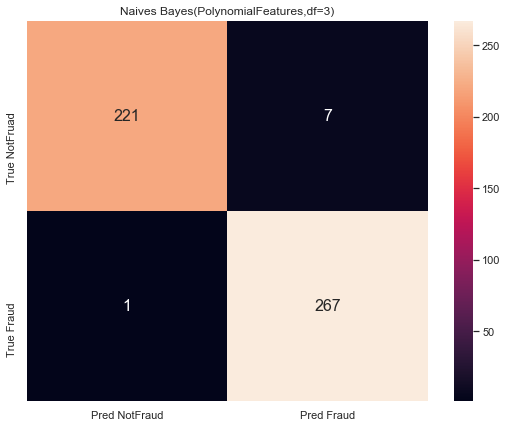

In [126]:
# Confusion Matrix
df_cm = pd.DataFrame(gnb2_cm,['True NotFruad','True Fraud'],['Pred NotFraud','Pred Fraud'])
plt.figure(figsize = (9,7))
sns.set(font_scale=1) #for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g')# font size
plt.title("Naives Bayes(PolynomialFeatures,df=3)")
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

After use PolynomialFeatures, it doesn't improve the accuarcy. So I think if we want to improve the accuarcy, we need get new features.

# ROC Curve

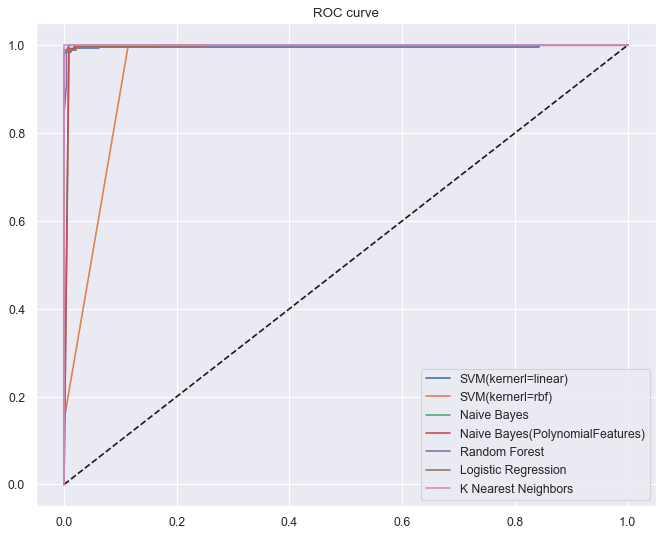

In [54]:
plt.figure(figsize=(10, 8),dpi=80, frameon=False, clear=True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_svm, tpr_svm, label='SVM(kernerl=linear)')
plt.plot(fpr_svm1, tpr_svm1, label='SVM(kernerl=rbf)')
plt.plot(fpr_gnb, tpr_gnb, label='Naive Bayes')
plt.plot(fpr_gnb1, tpr_gnb1, label="Naive Bayes(PolynomialFeatures)")
plt.plot(fpr_rdf, tpr_rdf, label='Random Forest')
plt.plot(fpr_lg, tpr_lg, label='Logistic Regression')
plt.plot(fpr_knn, tpr_knn, label='K Nearest Neighbors')

plt.title('ROC curve')
plt.legend(loc='best')
plt.show()